In [ ]:
!nvidia-smi

#1.&nbsp;Gather and Label Training Images


Data from Label Studio to label and export the images,

- An `images` folder containing the images
- A `labels` folder containing the labels in YOLO annotation format
- A `classes.txt` labelmap file that contains all the classes

# 2.&nbsp;Upload Image Dataset and Prepare Training Data

## 2.1 Upload images

We are uploading labled data that we exported from label-studio. (Images, Respective labels)

In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/Labeled_data.zip -d /content/custom_data


I wrote a Python script that will automatically create the required folder structure and randomly move 80% of dataset to the "train" folder and 10% to the "validation" folder.

In [ ]:
import os
import shutil
import random

def split_data(source_folder, output_base_folder='data', train_ratio=0.8):
    """
    Splits image and label data from a source folder into training and validation sets,
    placing them inside a specified output base folder.

    Args:
        source_folder (str): The path to the 'custom_data' folder containing 'images' and 'labels' subfolders.
        output_base_folder (str): The name of the base folder where 'train' and 'validation' will be created (e.g., 'data').
        train_ratio (float): The proportion of data to be used for training (e.g., 0.8 for 80%).
    """

    images_folder = os.path.join(source_folder, 'images')
    labels_folder = os.path.join(source_folder, 'labels')

    # Ensure source folders exist
    if not os.path.exists(images_folder):
        print(f"Error: Images folder not found at {images_folder}")
        return
    if not os.path.exists(labels_folder):
        print(f"Error: Labels folder not found at {labels_folder}")
        return

    # Create the main output base folder (e.g., 'data')
    os.makedirs(output_base_folder, exist_ok=True)

    # Create destination folders inside the output_base_folder
    # This ensures the desired final structure:
    # data/train/images, data/train/labels, data/validation/images, data/validation/labels
    for sub_dir in ['train', 'validation']:
        os.makedirs(os.path.join(output_base_folder, sub_dir, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_base_folder, sub_dir, 'labels'), exist_ok=True)

    print(f"Source images folder: {images_folder}")
    print(f"Source labels folder: {labels_folder}")
    print(f"Output base folder: {output_base_folder}")

    # Get all image filenames
    image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]

    # Shuffle the list of image files to ensure a random split
    random.shuffle(image_files)

    # Calculate the number of images for the training set
    num_train = int(len(image_files) * train_ratio)

    # Split the shuffled image files into training and validation sets
    train_files = image_files[:num_train]
    validation_files = image_files[num_train:]

    print(f"\nTotal images found: {len(image_files)}")
    print(f"Number of training images: {len(train_files)}")
    print(f"Number of validation images: {len(validation_files)}")

    # Process and copy files for both training and validation sets
    for file_list, split_name in [(train_files, 'train'), (validation_files, 'validation')]:
        print(f"\nCopying files to '{os.path.join(output_base_folder, split_name)}' directory...")
        for image_filename in file_list:
            # Extract the base filename (without extension) to find the corresponding label file
            base_filename, _ = os.path.splitext(image_filename)

            # Assuming label files have a .txt extension. Adjust if yours are different (e.g., .xml, .json)
            label_filename = base_filename + '.txt'

            # Define source and destination paths for the image file
            src_image_path = os.path.join(images_folder, image_filename)
            # Updated destination path to include output_base_folder
            dst_image_path = os.path.join(output_base_folder, split_name, 'images', image_filename)

            # Define source and destination paths for the label file
            src_label_path = os.path.join(labels_folder, label_filename)
            # Updated destination path to include output_base_folder
            dst_label_path = os.path.join(output_base_folder, split_name, 'labels', label_filename)

            try:
                # Copy the image file
                shutil.copy(src_image_path, dst_image_path)

                # Copy the label file if it exists
                if os.path.exists(src_label_path):
                    shutil.copy(src_label_path, dst_label_path)
                else:
                    print(f"  Warning: Label file not found for {image_filename} (expected: {src_label_path}). Skipping label copy for this image.")
            except Exception as e:
                print(f"  Error copying {image_filename} or its label: {e}")

    print("\nData splitting complete!")

# --- Configuration ---
# Specify the path to your 'custom_data' folder.
custom_data_folder_path = '/content/custom_data'

# Specify the desired base folder for the output (e.g., 'data')
output_dataset_folder = '/content/data'

# Call the function to perform the split
split_data(custom_data_folder_path, output_base_folder=output_dataset_folder, train_ratio=0.8)

Source images folder: /content/custom_data/images
Source labels folder: /content/custom_data/labels
Output base folder: /content/data

Total images found: 17
Number of training images: 13
Number of validation images: 4

Copying files to '/content/data/train' directory...

Copying files to '/content/data/validation' directory...

Data splitting complete!


# 3.&nbsp;Install Requirements (Ultralytics)

Next, we'll install the Ultralytics library in this Google Colab instance. This Python library will be used to train the YOLO model.

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.5 MB/s eta 0:00:00


# 4.&nbsp;Configure Training



Code block below to automatically generate a `data.yaml` configuration file. Make sure you have a labelmap file located at `custom_data/classes.txt`.

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 2
names:
- door
- windows


# 5.&nbsp;Train Model

## 5.1 Training Parameters



**Number of epochs (`epochs`)**

  We will keep epochs 1000, (Early stopping (300 to 400)


**Resolution (`imgsz`)**
  YOLO models are typically trained and inferenced at a 640x640 resolution.  


## 5.2 Run Training!

In [ ]:
!yolo detect train data=/content/data.yaml model=yolov8n.pt epochs=1000 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 6.25M/6.25M [00:00<00:00, 62.7MB/s]
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1000, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, io

#6.&nbsp;Test Model

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

image 1/4 /content/data/validation/images/a84a5ba5-14.png: 448x640 4 doors, 4 windowss, 195.2ms
image 2/4 /content/data/validation/images/cad34834-7.png: 640x640 9 doors, 4 windowss, 243.8ms
image 3/4 /content/data/validation/images/f25bd5d1-15.png: 448x640 12 doors, 1 windows, 160.0ms
image 4/4 /content/data/validation/images/fbfe6f75-4.png: 640x448 2 doors, 2 windowss, 170.5ms
Speed: 5.4ms preprocess, 192.4ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


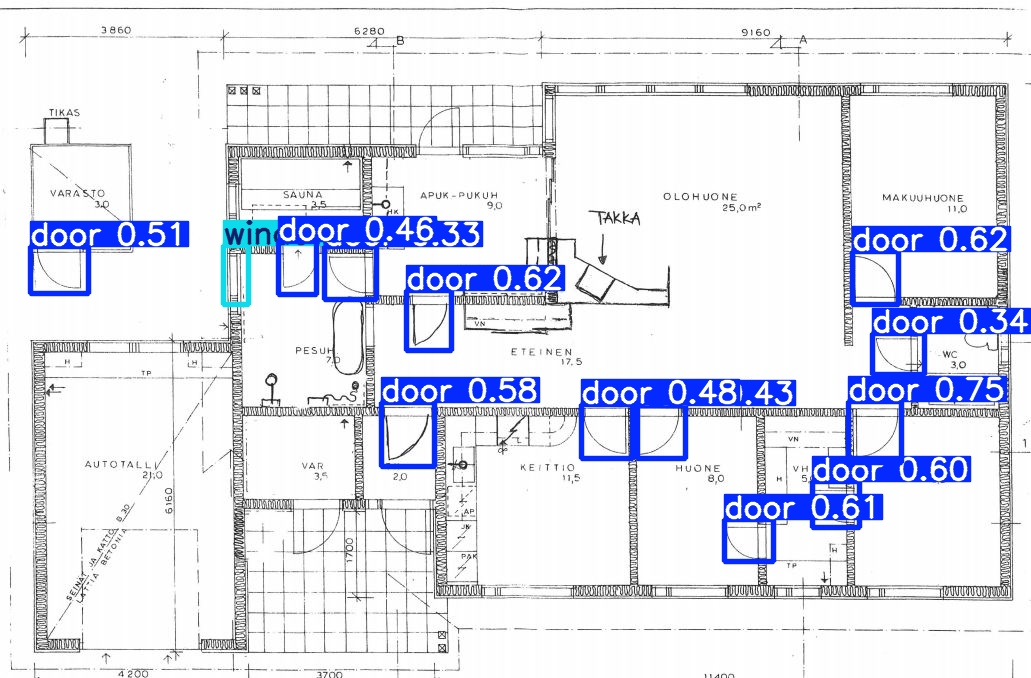

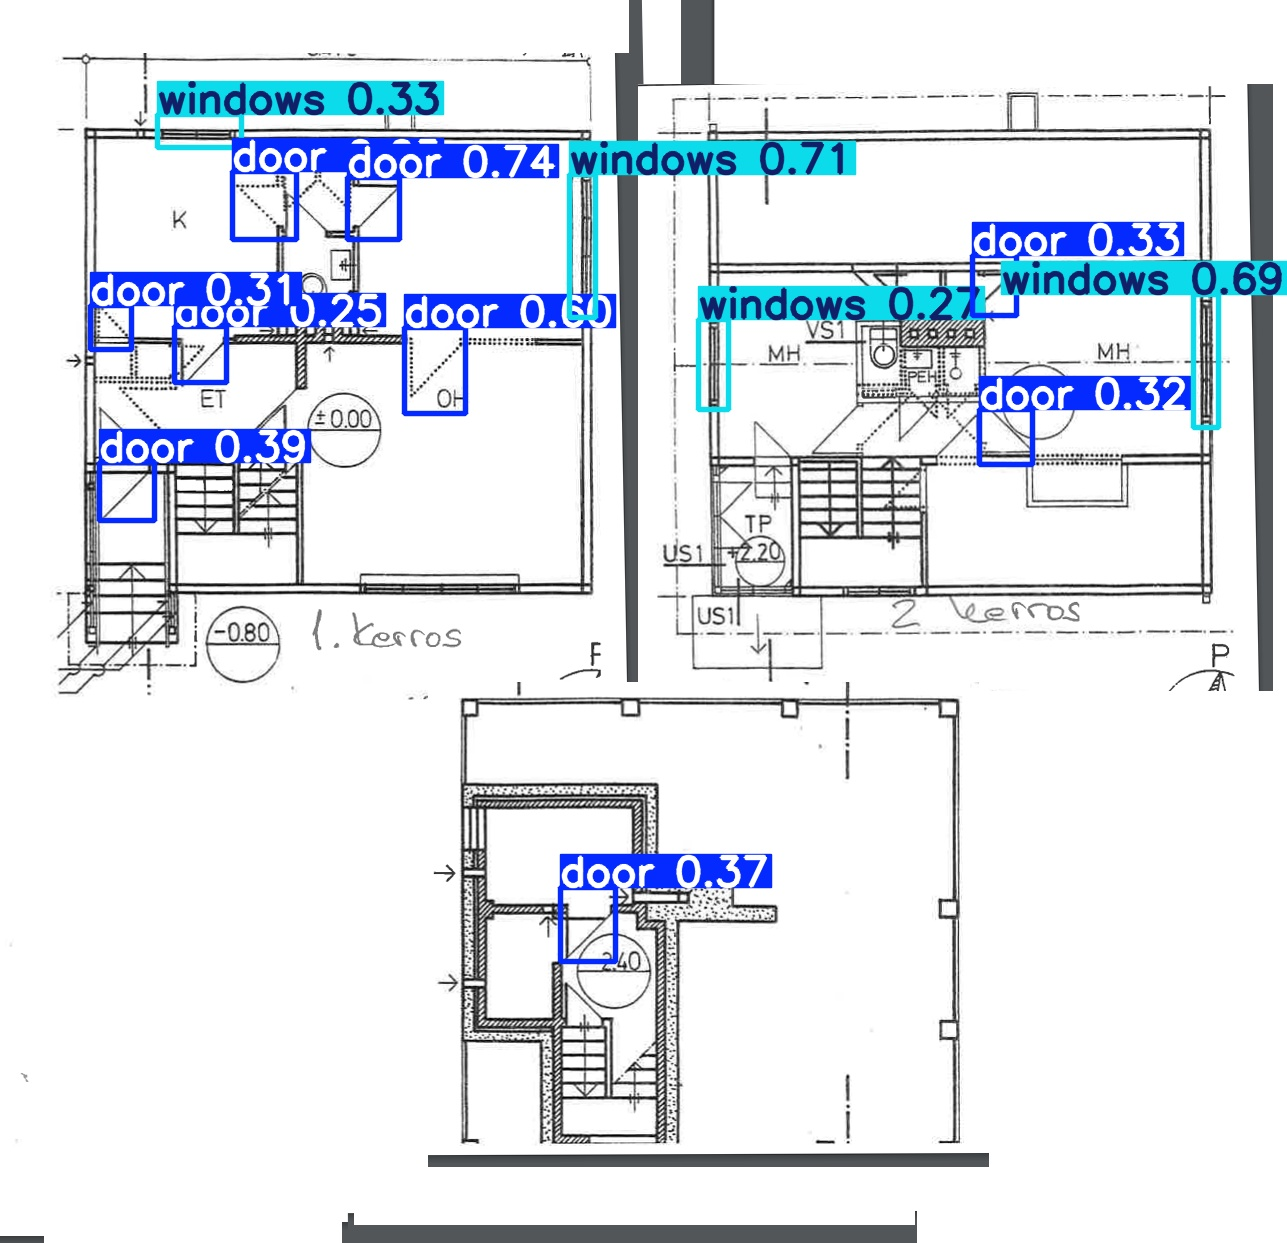

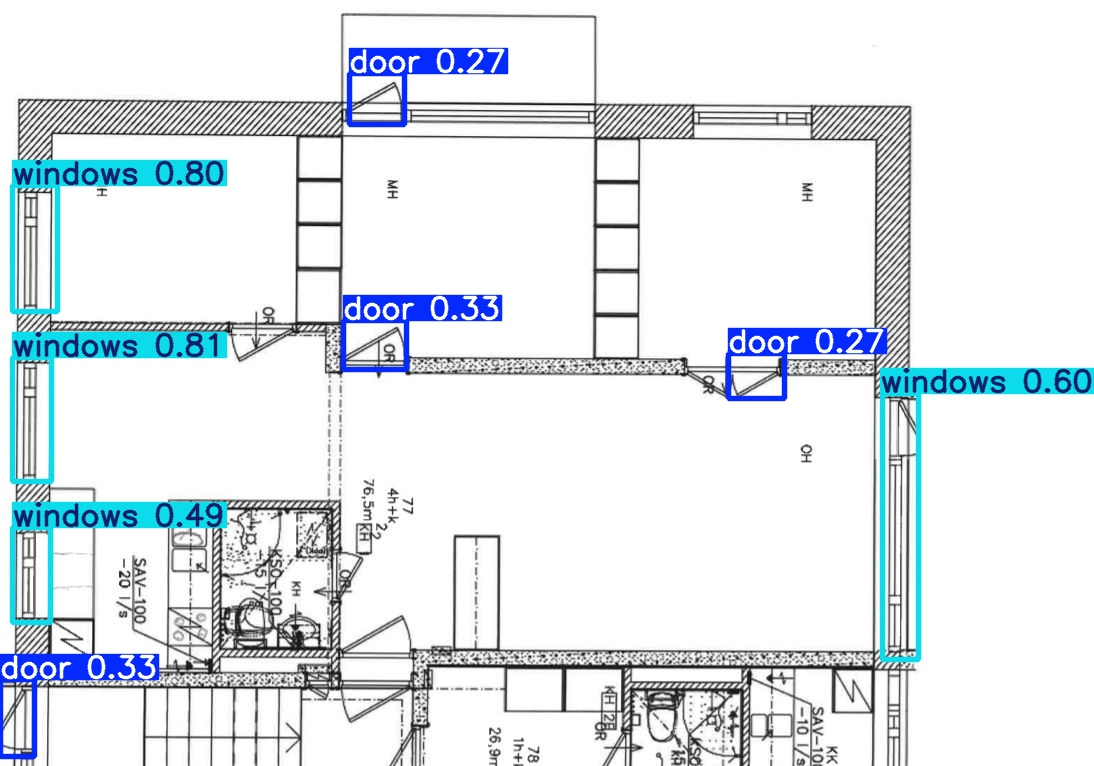

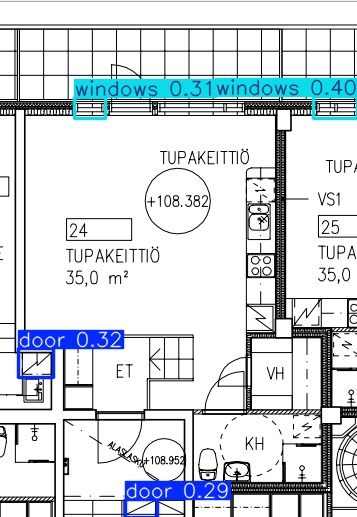

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')
